In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression


In [18]:
df=pd.read_csv('abalone.data.csv')
df.head()

,Sex,Length,Diameter,Height,Whole weightShucked weight,Viscera weight,Shell weight,Rings,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Sex                         4177 non-null   object 
 1   Length                      4177 non-null   float64
 2   Diameter                    4177 non-null   float64
 3   Height                      4177 non-null   float64
 4   Whole weightShucked weight  4177 non-null   float64
 5   Viscera weight              4177 non-null   float64
 6   Shell weight                4177 non-null   float64
 7   Rings                       4177 non-null   float64
 8   Age                         4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [20]:
#编码离散特征
df['Sex']=df['Sex'].map({'M':1,'F':2,'I':3})
columns=list(df.columns)[1:-1]
df[columns]=df[columns]*200
df.head()


,Sex,Length,Diameter,Height,Whole weightShucked weight,Viscera weight,Shell weight,Rings,Age
0,1,91.0,73.0,19.0,102.8,44.9,20.2,30.0,15
1,1,70.0,53.0,18.0,45.1,19.9,9.7,14.0,7
2,2,106.0,84.0,27.0,135.4,51.3,28.3,42.0,9
3,1,88.0,73.0,25.0,103.2,43.1,22.8,31.0,10
4,3,66.0,51.0,16.0,41.0,17.9,7.9,11.0,7


In [21]:
#查看特征与目标之间的相关性
X = df.copy()
y = X.pop("Age")

#MI分数计算
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y,)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=True)
    return mi_scores

mi_scores = make_mi_scores(X, y)

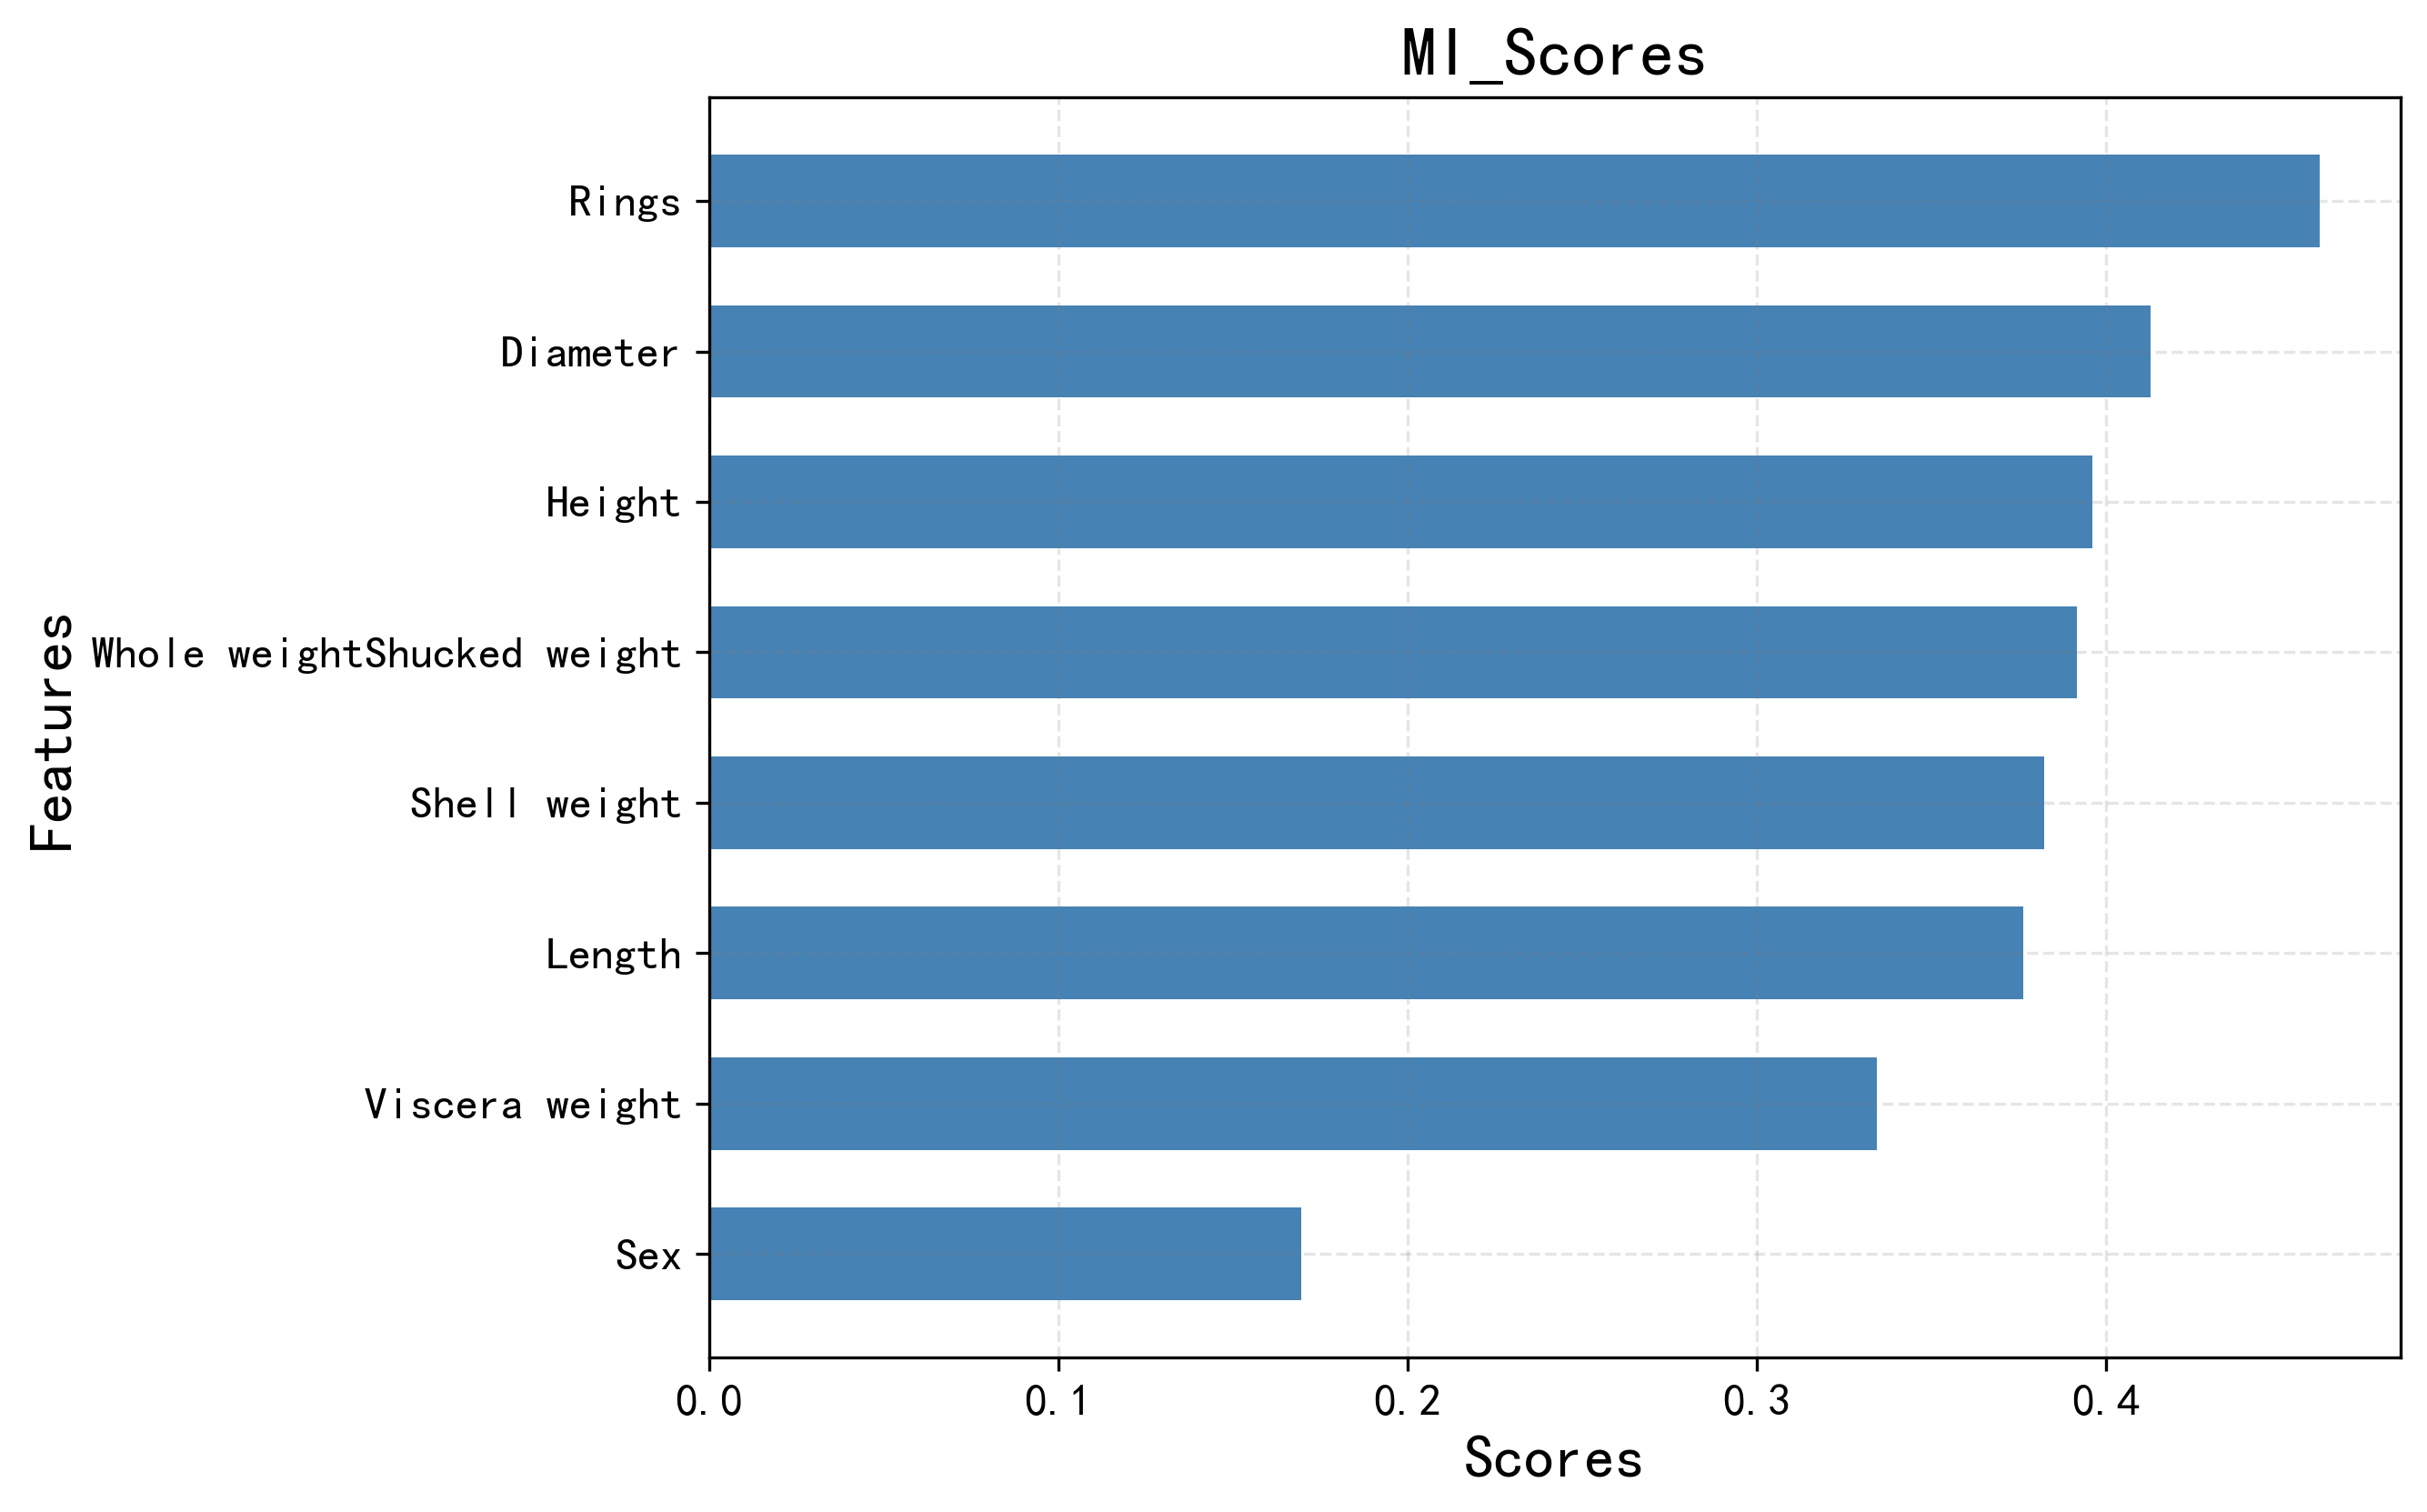

In [22]:
width=np.arange(len(mi_scores))*1.3
ticks=list(mi_scores.index)
plt.figure(figsize=(8,6),dpi=300)
plt.barh(width,mi_scores,alpha=1,color='steelblue')
plt.yticks(width,ticks,fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Features',fontsize=16)
plt.xlabel('Scores',fontsize=16)
plt.title('MI_Scores',fontsize=18)
plt.grid(alpha=0.2,color='gray',linestyle='--',)

In [23]:
#划分特征与目标
columns=list(df.columns)
features=columns[:-1]
labels=columns[-1]
x_data=df[features].values.astype(np.float32)
y_data=df[labels].values.astype(np.float32).reshape(-1,1)

In [24]:
#划分数据集，70%训练集，20%验证集，10%测试集
train_size=int(len(x_data)*0.7)
val_size=int(len(x_data)*0.2)
x_train_raw,x_val_raw,x_test_raw=np.split(x_data,[train_size,train_size+val_size])
y_train_raw,y_val_raw,y_test_raw=np.split(y_data,[train_size,train_size+val_size])

In [25]:
#数据标准化
scaler=StandardScaler()
x_train_scaled=scaler.fit_transform(x_train_raw)
x_val_scaled=scaler.transform(x_val_raw)
x_test_scaled=scaler.transform(x_test_raw)
y_train_scaled=scaler.fit_transform(y_train_raw)
y_val_scaled=scaler.transform(y_val_raw)
y_test_scaled=scaler.transform(y_test_raw)

In [26]:
#将原始数据转换为tensor
y_val_raw=torch.tensor(y_val_raw)
y_test_raw=torch.tensor(y_test_raw)
#将标准化数据转换为tensor
x_train=torch.tensor(x_train_scaled,dtype=torch.float32)
y_train=torch.tensor(y_train_scaled,dtype=torch.float32)
x_val=torch.tensor(x_val_scaled,dtype=torch.float32)
y_val=torch.tensor(y_val_scaled,dtype=torch.float32)
x_test=torch.tensor(x_test_scaled,dtype=torch.float32)
y_test=torch.tensor(y_test_scaled,dtype=torch.float32)

In [27]:
#封装训练数据
train_data=TensorDataset(x_train,y_train)

In [28]:
#定义网络
class DNN(nn.Module):
    def __init__(self,in_dim=8,hidden_dim=[128,64,32],out_dim=1,dropout=0.1):
        super(DNN,self).__init__() 
        self.net=nn.Sequential(
            nn.Linear(in_dim,hidden_dim[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[0],hidden_dim[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[1],hidden_dim[2]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim[2],out_dim),
          
        )
    def forward(self,x):
        return self.net(x)
    

In [29]:
#解码粒子
def decode_particle(p):
    '''
    将p:[0:1]*6映射为模型参数
    返回参数字典，如下：
    {
        'hidden_dim':隐藏层神经元个数,
        'dropout':dropout概率,
        'lr':学习率,
        'weight_decay':权重衰减
    }
    '''
    x1_hidden,x2_hidden,x3_hidden=p[0].item(),p[1].item(),p[2].item()
    x_dropout,x_lr,x_weight_decay=p[3].item(),p[4].item(),p[5].item()

    # 隐藏层神经元个数[16:256]
    x1_hidden=int(16+x1_hidden*(256-16))
    x2_hidden=int(16+x2_hidden*(256-16))
    x3_hidden=int(16+x3_hidden*(256-16))
 
    hidden_dim=[x1_hidden,x2_hidden,x3_hidden]

    #dropout[0.0:0.5]
    dropout=0.0+x_dropout*(0.5-0.0)

    #学习率[1e-6:1e-3]
    log_lr=-6+x_lr*(-3-(-6))
    lr=10**log_lr

    #权重衰减[1e-6:1e-3]
    log_weight_decay=-6+x_weight_decay*(-3-(-6))
    weight_decay=10**log_weight_decay

    return{
        'hidden_dim':hidden_dim,
        'dropout':dropout,
        'lr':lr,
        'weight_decay':weight_decay}



In [30]:
def train_and_val(hparams,epochs=5,batch_size=32):
    model=DNN(hidden_dim=hparams['hidden_dim'],dropout=hparams['dropout']).to('cuda:0')
    optimizer=torch.optim.Adam(model.parameters(),lr=hparams['lr'])
    criterion=nn.MSELoss()
    train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)
    #进行少量训练
    model.train()
    for epoch in range(epochs):
        for x_batch,y_batch in train_loader:
            pred=model(x_batch.to('cuda:0'))
            loss=criterion(pred,y_batch.to('cuda:0'))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    #进行验证
    model.eval()
    with torch.no_grad():
        val_pred=model(x_val.to('cuda:0'))
        val_pred=scaler.inverse_transform(val_pred.cpu().numpy())
        val_pred=torch.tensor(val_pred)
        val_loss=criterion(val_pred,y_val_raw)
        
    return val_loss.item()


In [31]:
#计算适应度
def fitness(p):
    hparams=decode_particle(p)
    val_loss=train_and_val(hparams)
    return val_loss

In [32]:
class PsoSearchHparams():
    def __init__(self,pop=10,dim=6,maxiter=10,w=0.7,c1=1.5,c2=1.5):
        self.pop=pop
        self.dim=dim
        self.maxiter=maxiter
        self.w=w
        self.c1=c1
        self.c2=c2

        #初始化位置和速度
        self.x=torch.rand(pop,dim)
        self.v=torch.randn(pop,dim)*0.1

        #初始化个体最优位置和适应度
        self.p_best=self.x.clone()
        self.p_best_fit=torch.tensor([fitness(x) for x in self.p_best])

        #初始化全局最优位置和适应度
        best_id=torch.argmin(self.p_best_fit)
        self.g_best=self.p_best[best_id].clone()
        self.g_best_fit=self.p_best_fit[best_id].item()
    
    def optimize(self):
        for iter in range(self.maxiter):
            for i in range(self.pop):
                r1=torch.rand(self.dim)
                r2=torch.rand(self.dim)

                #更新速度
                self.v[i]=self.w*self.v[i]+self.c1*r1*(self.p_best[i]-self.x[i])+self.c2*r2*(self.g_best-self.x[i])

                #更新位置,并限制在0-1之间
                self.x[i]=torch.clamp(self.x[i]+self.v[i],0.0,1.0)

                #计算适应度
                fit=fitness(self.x[i])

                #更新个体最优位置和适应度
                if fit<self.p_best_fit[i]:
                    self.p_best[i]=self.x[i].clone()
                    self.p_best_fit[i]=fit
                    
                    #更新全局最优位置和适应度
                    if fit<self.g_best_fit:
                        self.g_best=self.x[i].clone()
                        self.g_best_fit=fit
            print('当前训练轮数:{},验证集最好损失 :{:.4f}'.format(iter+1,self.g_best_fit))
        return self.g_best


In [33]:
#进行超参数搜索
pso=PsoSearchHparams()
particle=pso.optimize()
hparams=decode_particle(particle)
print(f'搜索到的最佳参数为{hparams}')

当前训练轮数:1,验证集最好损失 :3.8972
当前训练轮数:2,验证集最好损失 :3.8437
当前训练轮数:3,验证集最好损失 :3.7618
当前训练轮数:4,验证集最好损失 :3.7618
当前训练轮数:5,验证集最好损失 :3.7618
当前训练轮数:6,验证集最好损失 :3.7618
当前训练轮数:7,验证集最好损失 :3.7618
当前训练轮数:8,验证集最好损失 :3.7618
当前训练轮数:9,验证集最好损失 :3.7618
当前训练轮数:10,验证集最好损失 :3.7618
搜索到的最佳参数为{'hidden_dim': [256, 29, 251], 'dropout': 0.040111243724823, 'lr': 0.001, 'weight_decay': 5.730825907356203e-06}


In [34]:
#完整训练并测试
def train_and_test(hparams,epochs=100,batch_size=32,patience=10):
    model=DNN(hidden_dim=hparams['hidden_dim'],dropout=hparams['dropout']).to('cuda:0')
    optimizer=torch.optim.Adam(model.parameters(),lr=hparams['lr'],weight_decay=hparams['weight_decay'])
    criterion=nn.MSELoss()
    train_loader=DataLoader(train_data,shuffle=True,batch_size=batch_size)

    #收集历史损失，便于画图
    train_losses=[]
    val_losses=[]

    best_val_loss=np.inf
    best_params=[]
    no_improve_count=0

    for epoch in range(epochs):
        train_loss=0
        #训练
        model.train()
        for x_batch,y_batch in train_loader:
            x_batch,y_batch=x_batch.to('cuda:0'),y_batch.to('cuda:0')
            optimizer.zero_grad()
            pred=model(x_batch)
            loss=criterion(pred,y_batch)
            loss.backward()
            optimizer.step()

            #记录绝对损失
            with torch.no_grad():
                pred=scaler.inverse_transform(pred.cpu().numpy())
                pred=torch.tensor(pred)
                y_batch=scaler.inverse_transform(y_batch.cpu().numpy())
                y_batch=torch.tensor(y_batch)
                loss=criterion(pred,y_batch)
                train_loss+=loss.item()

        train_losses.append(train_loss/len(train_loader))

        #验证
        model.eval()
        with torch.no_grad():
             pred=model(x_val.to('cuda:0'))
             pred=scaler.inverse_transform(pred.cpu().numpy())
             pred=torch.tensor(pred)
             loss=criterion(pred,y_val_raw)
             val_loss=loss.item()
             val_losses.append(val_loss)

        #更新最小验证损失和参数
        if val_loss<best_val_loss:
            best_val_loss=val_loss
            best_params=[p.data.clone() for p in model.parameters()]
            no_improve_count=0
        else:
            no_improve_count+=1
        
        #早停
        if no_improve_count>=patience:
            print(f'早停触发于第{epoch+1}轮')
            break

        #打印训练和验证损失
        if (epoch+1)%10==0:
            print(f'第{epoch+1}轮训练损失：{train_loss/len(train_loader):.4f},验证损失：{val_loss:.4f}')

    #加载最佳参数
    with torch.no_grad():
        for p,best_p in zip(model.parameters(),best_params):
            p.copy_(best_p)


    #测试
    model.eval()
    with torch.no_grad():
        pred=model(x_test.to('cuda:0'))
        test_out=pred.cpu().numpy()
        test_out=scaler.inverse_transform(test_out)
        pred=torch.tensor(test_out)
        loss=criterion(pred,y_test_raw)
        test_loss=loss.item()
        print(f'测试损失：{test_loss:.4f}')

    return train_losses,val_losses,test_out
    


In [35]:
#进行完整训练和测试
train_losses,val_losses,test_out=train_and_test(hparams,epochs=100,batch_size=32,patience=10)

第10轮训练损失：4.4893,验证损失：3.9365
第20轮训练损失：4.3583,验证损失：3.7088
早停触发于第27轮
测试损失：3.9283


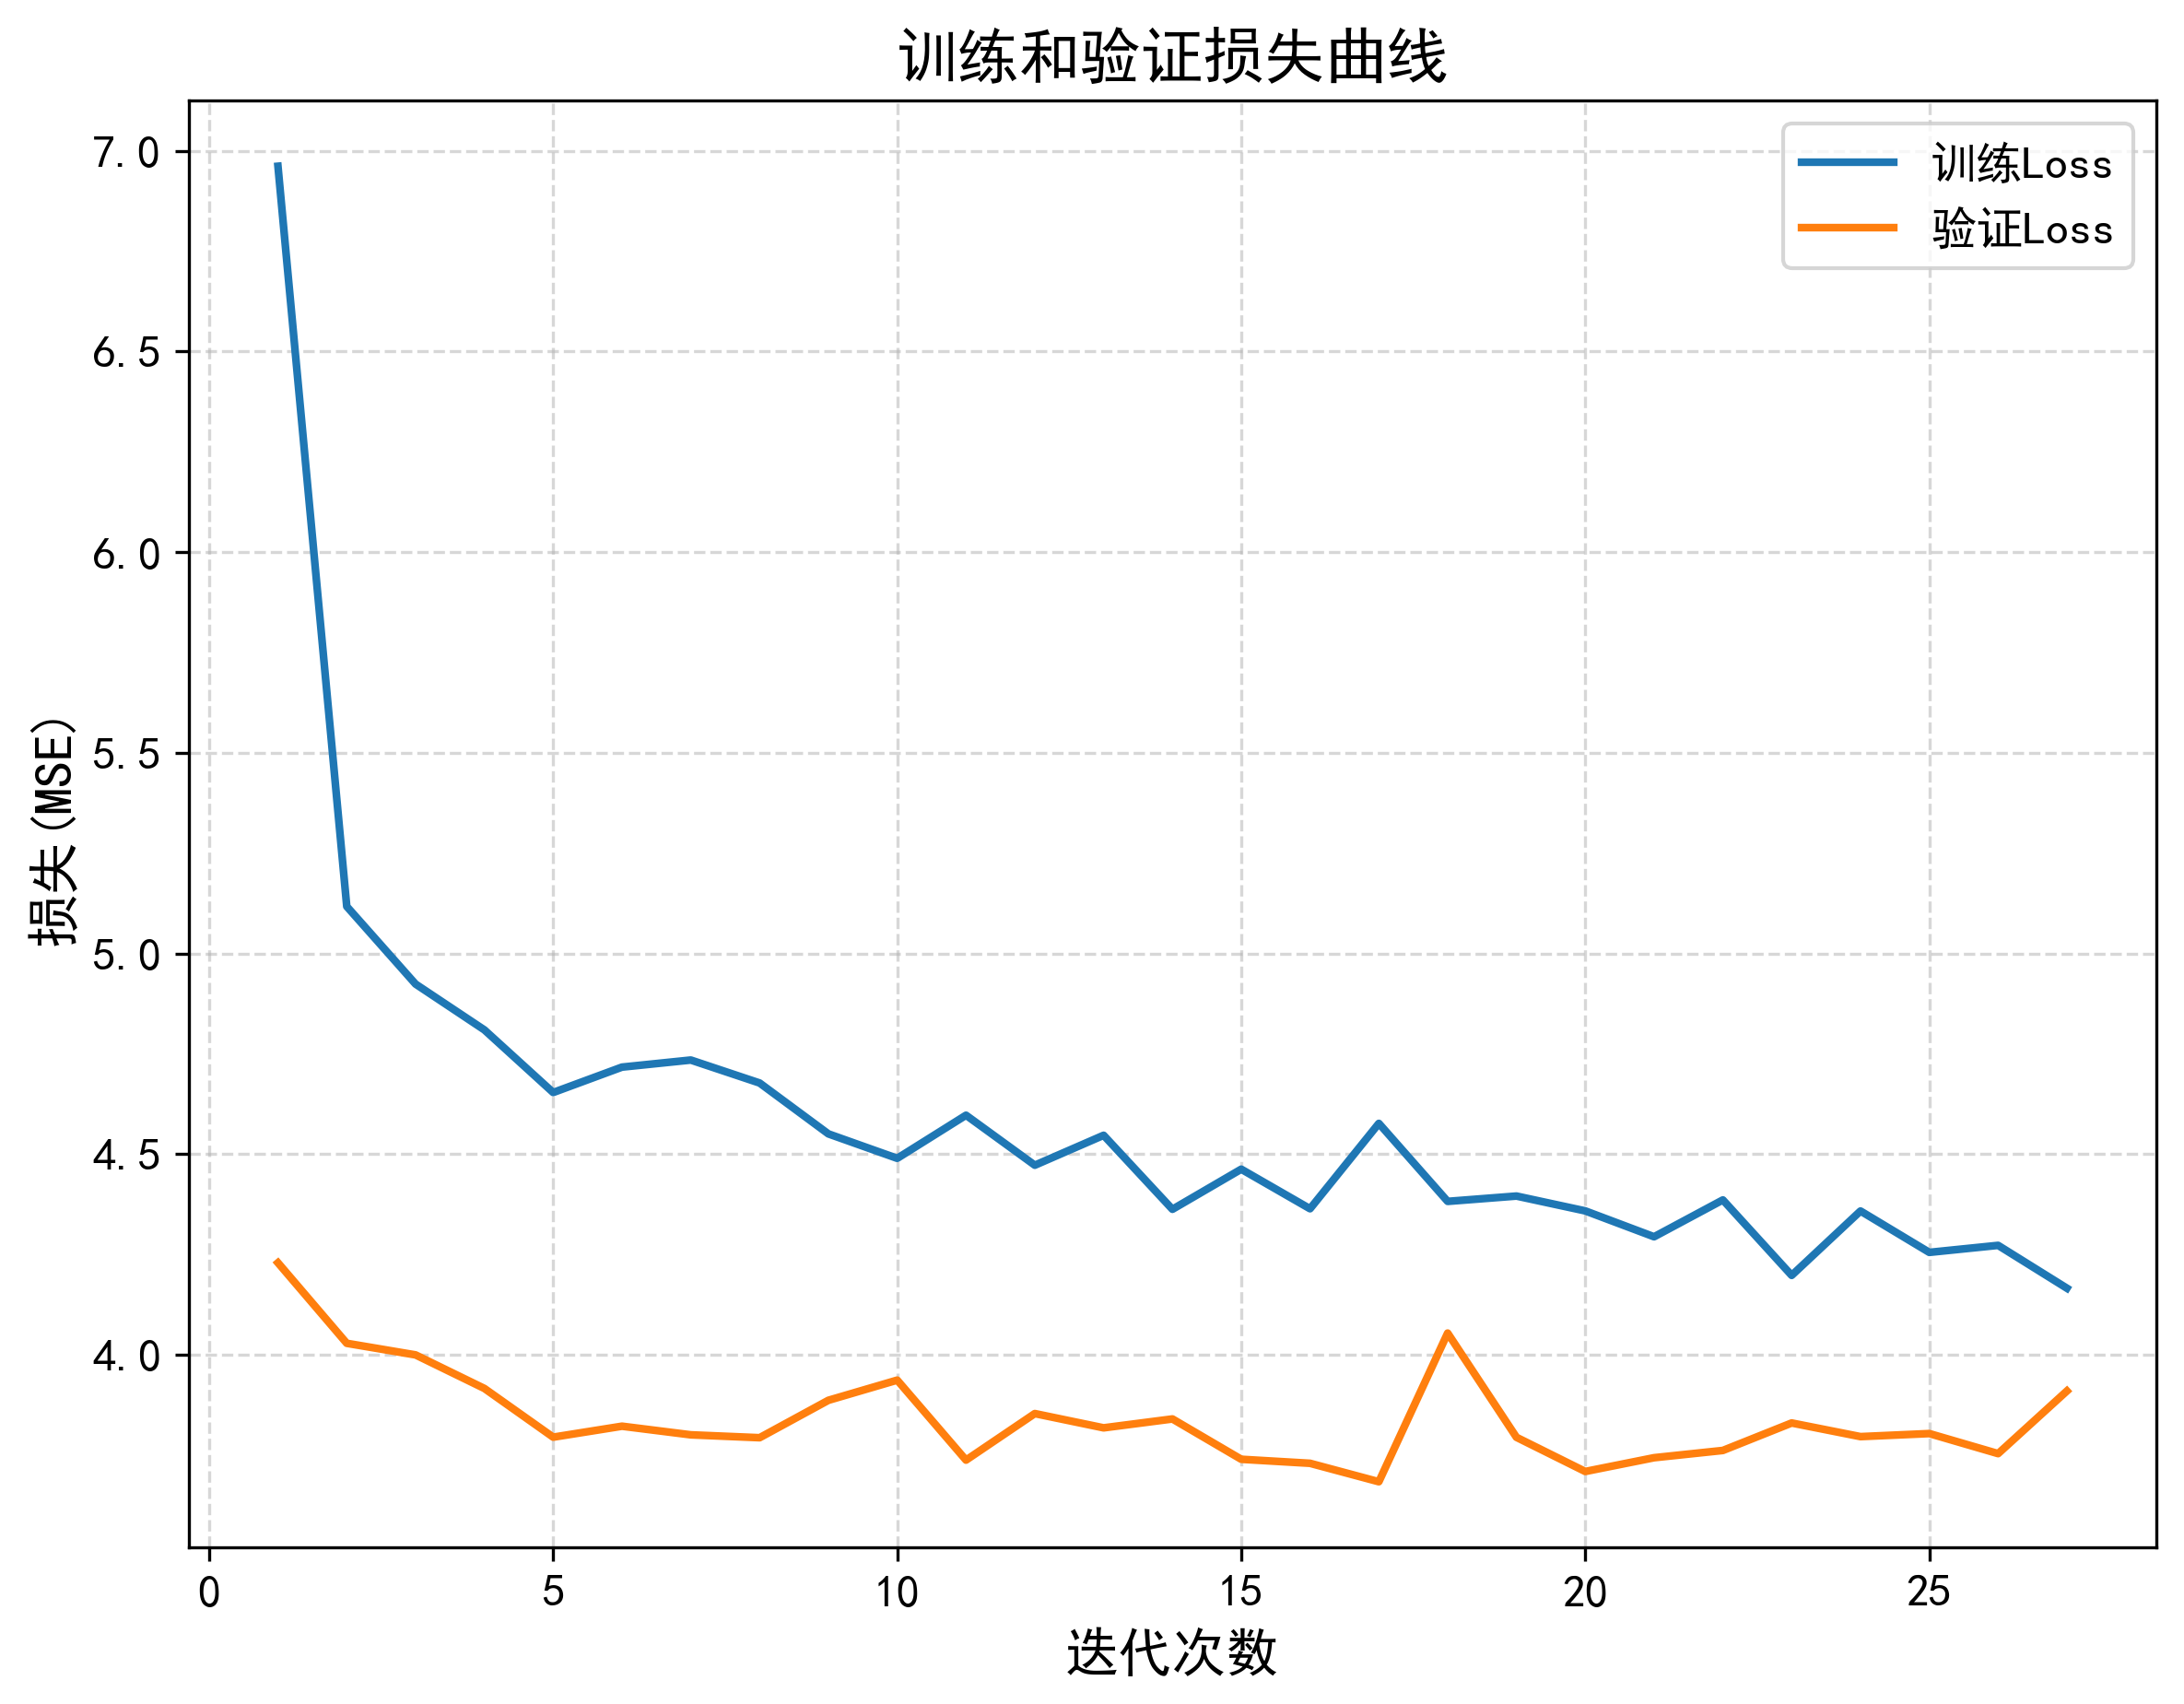

In [36]:

plt.figure(figsize=(8,6),dpi=300)
plt.plot(range(1,len(train_losses)+1),train_losses,label='训练Loss',linewidth=2)
plt.plot(range(1,len(val_losses)+1),val_losses,label='验证Loss',linewidth=2)
plt.xlabel('迭代次数',fontsize=14)
plt.ylabel('损失(MSE)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True,linestyle='--',alpha=0.5)
plt.tight_layout()
plt.title('训练和验证损失曲线',fontsize=16)
plt.savefig('训练和验证损失曲线.png')

Text(0.5, 1.0, 'predict_vs_true')

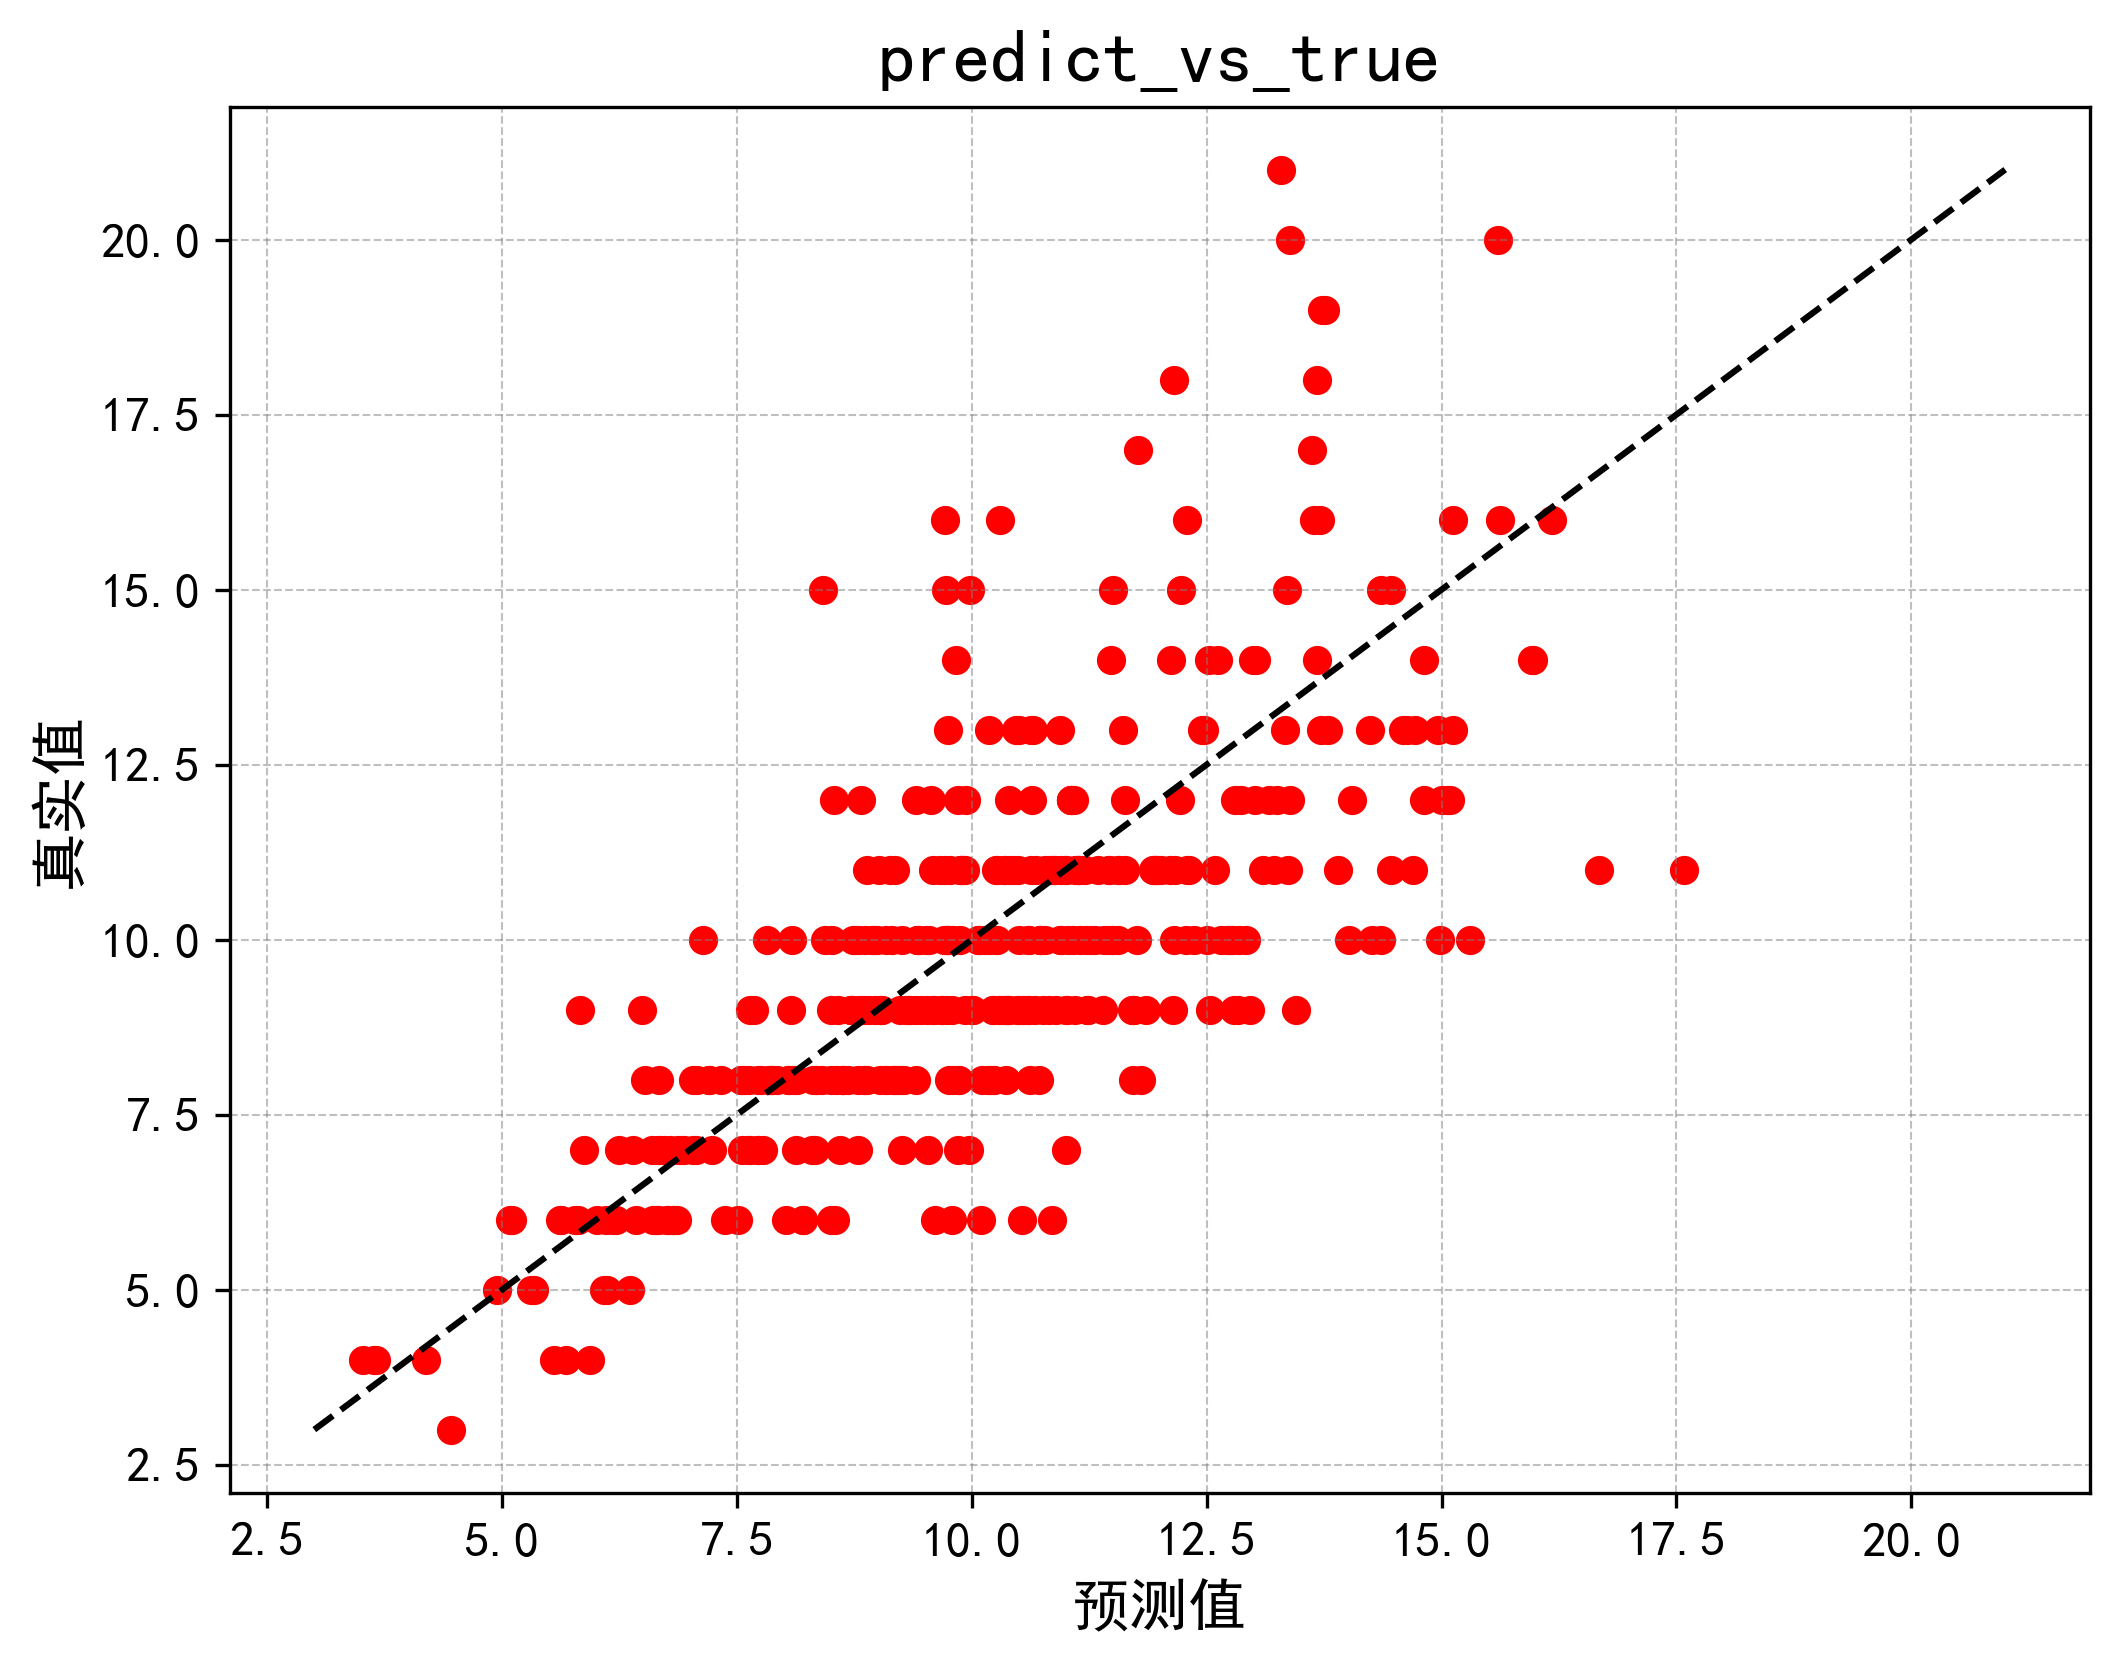

In [37]:
plt.figure(figsize=(8,6),dpi=300)
plt.scatter(test_out,y_test_raw,alpha=1,color='red')
plt.plot([y_test_raw.min(),y_test_raw.max()],[y_test_raw.min(),y_test_raw.max()],'k--',lw=1.5,)
plt.xlabel('预测值',fontsize=14)
plt.ylabel('真实值',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(linestyle='--',alpha=0.5,color='gray',linewidth=0.5)
plt.title('predict_vs_true',fontsize=18)



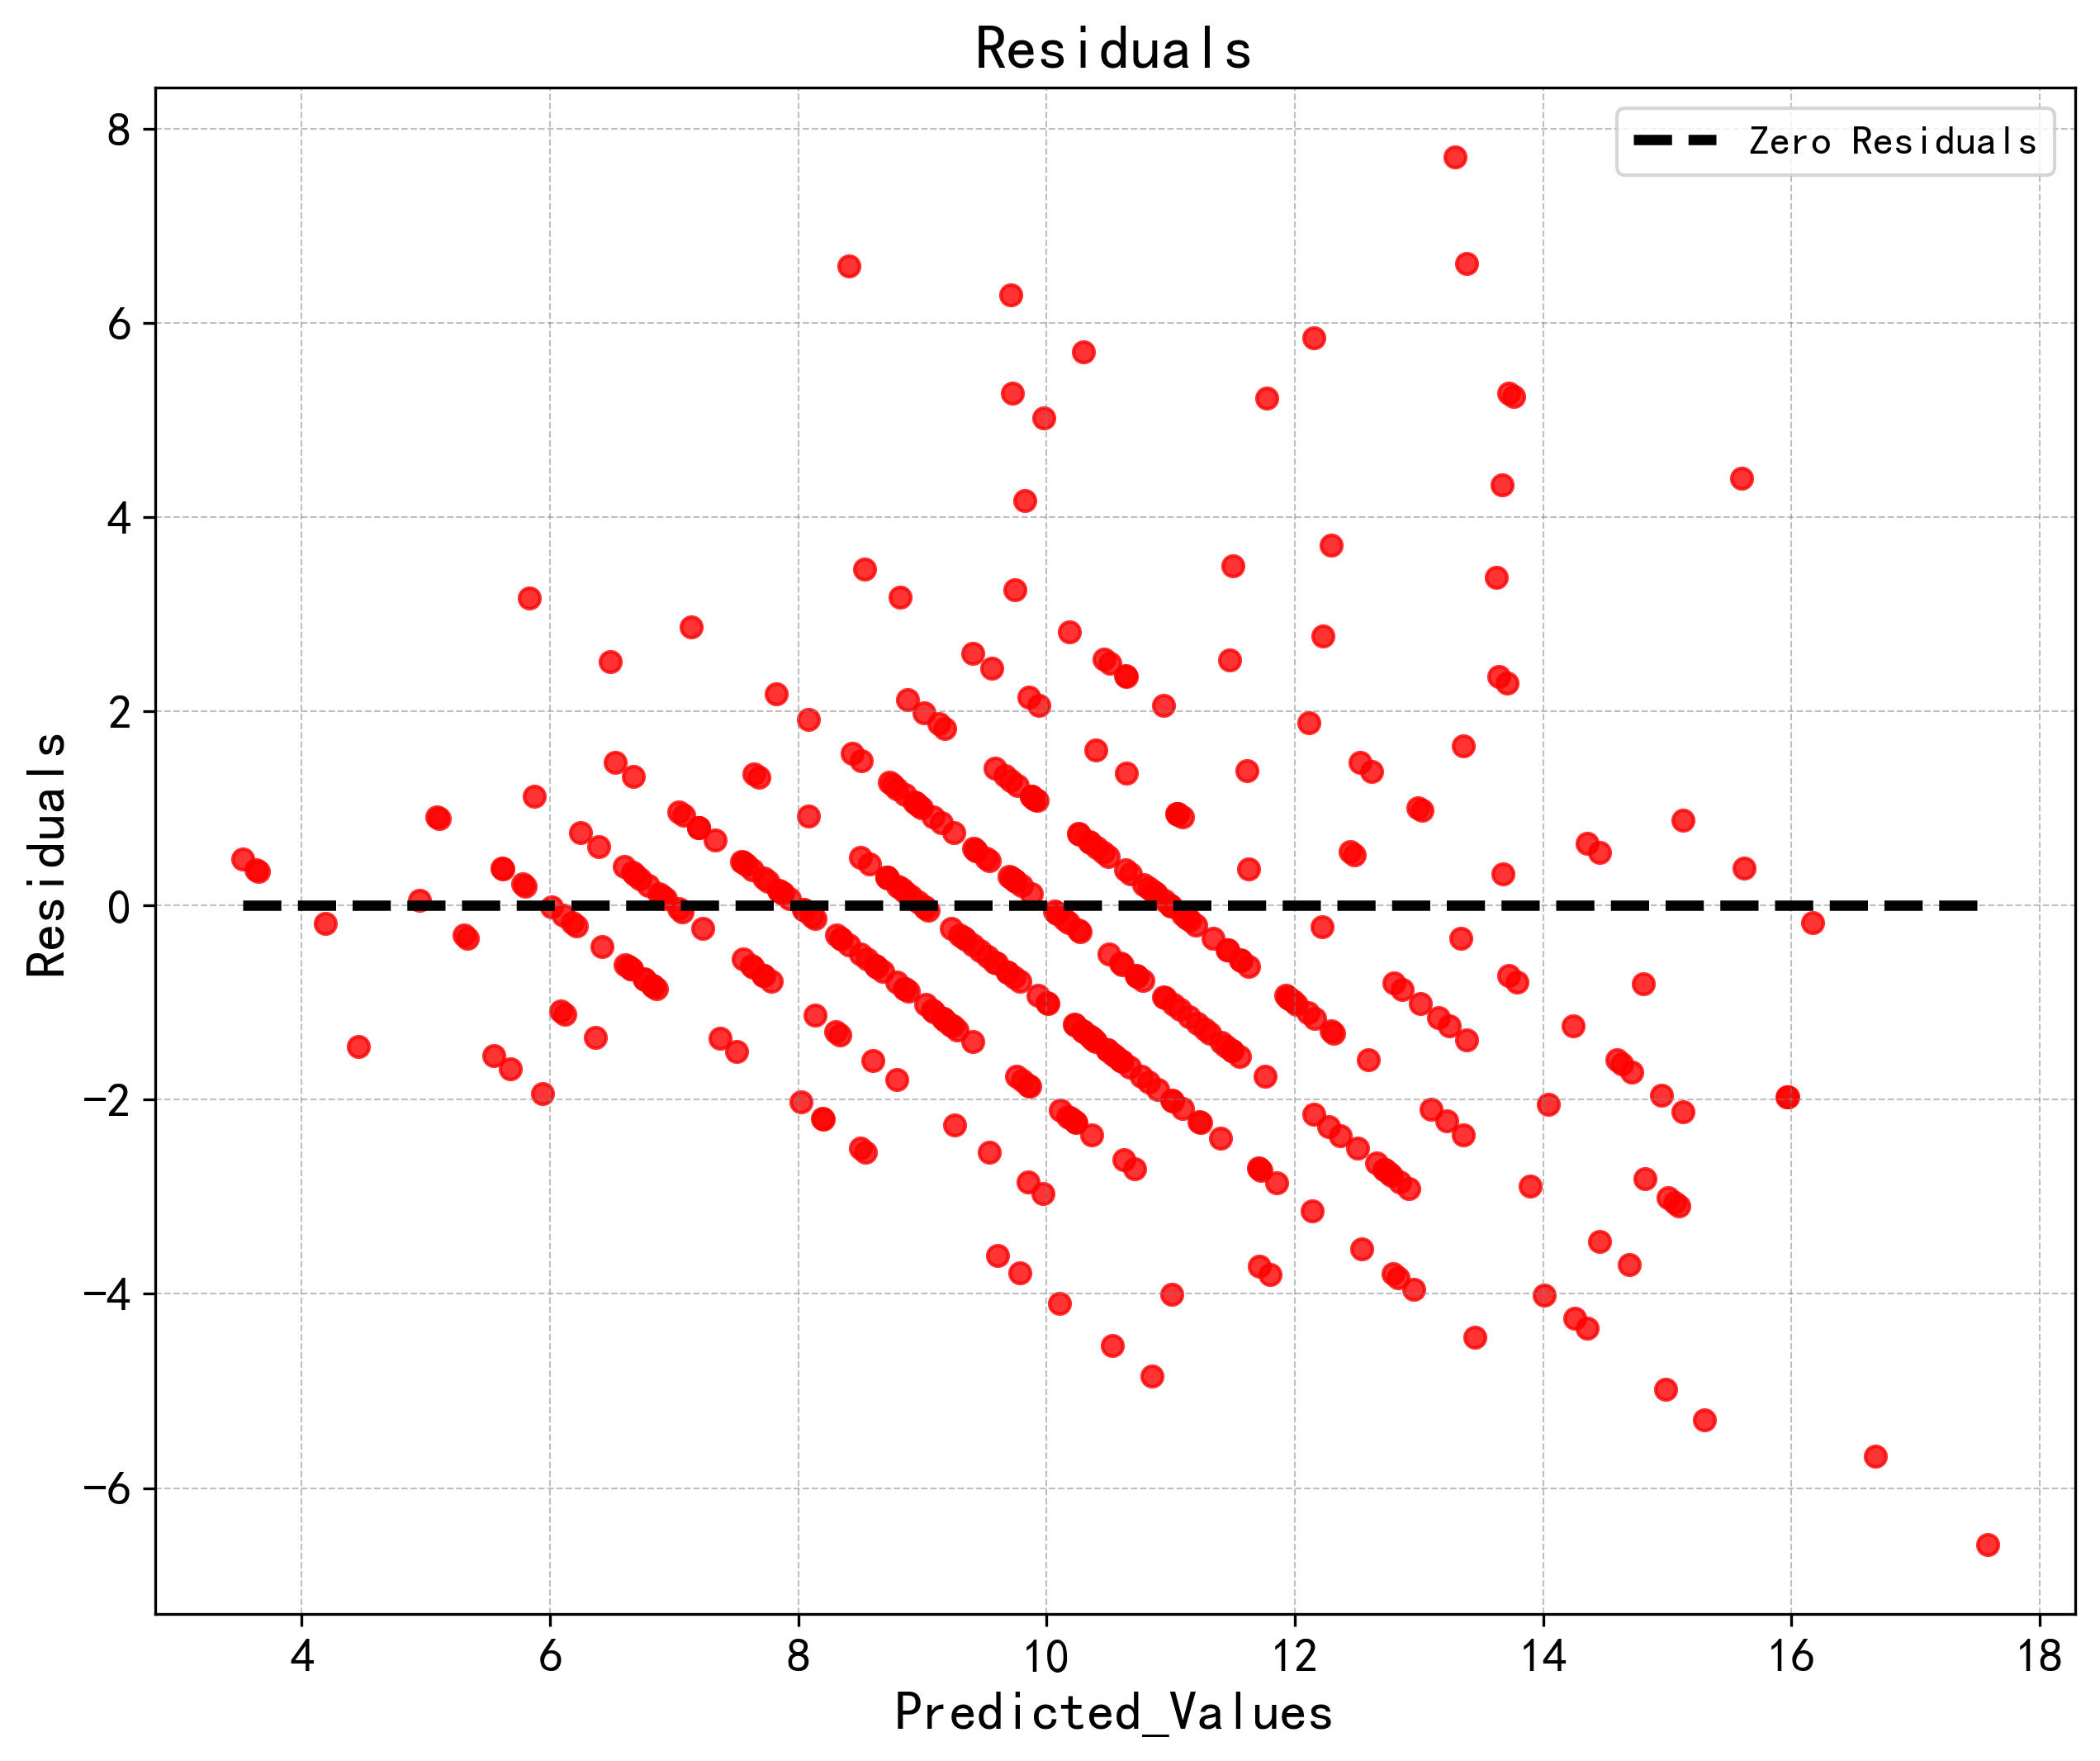

In [38]:
residuals = y_test_raw - test_out
plt.figure(figsize=(10,8),dpi=300)
plt.scatter(test_out,residuals,color='red',alpha=0.8)
plt.plot([test_out.min(),test_out.max()],[0,0],color='black',linestyle='--',alpha=1,linewidth=3,label='Zero Residuals')
plt.grid(linestyle='--',alpha=0.5,color='gray',linewidth=0.5)
plt.title('Residuals',fontsize=18)
plt.xlabel('Predicted_Values',fontsize=16)
plt.ylabel('Residuals',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)